# 第12章 LOWESS图
## 12.1 引言

预测问题
对于预测问题，回归中最简单的线性回归，是以线性的方法拟合出数据的趋势。但是对于有周期性，波动性的数据，并不能简单以线性的方式拟合，否则模型会偏差较大，而局部加权回归（lowess）能较好的处理这种问题。可以拟合出一条符合整体趋势的线，进而做预测。

## 平滑问题
同时，局部加权回归（lowess）也能较好的解决平滑问题。在做数据平滑的时候，会有遇到有趋势或者季节性的数据，对于这样的数据，我们不能使用简单的均值正负3倍标准差以外做异常值剔除，需要考虑到趋势性等条件。使用局部加权回归，可以拟合一条趋势线，将该线作为基线，偏离基线距离较远的则是真正的异常值点。
实际上，局部加权回归（Lowess）主要还是处理平滑问题的多，因为预测问题，可以有更多模型做的更精确。但就平滑来说，Lowess很直观而且很有说服力。

## 二、算法讲解
2.1 算法思想
局部加权回归（Lowess）的大致思路是：以一个点$x$为中心，向前后截取一段长度为$frac$的数据，对于该段数据用权值函数$w$做一个加权的线性回归，记$(x,\hat{y})$为该回归线的中心值，其中$\hat{y}$为拟合后曲线对应值。对于所有的$n$个数据点则可以做出$n$条加权回归线，每条回归线的中心值的连线则为这段数据的Lowess曲线。





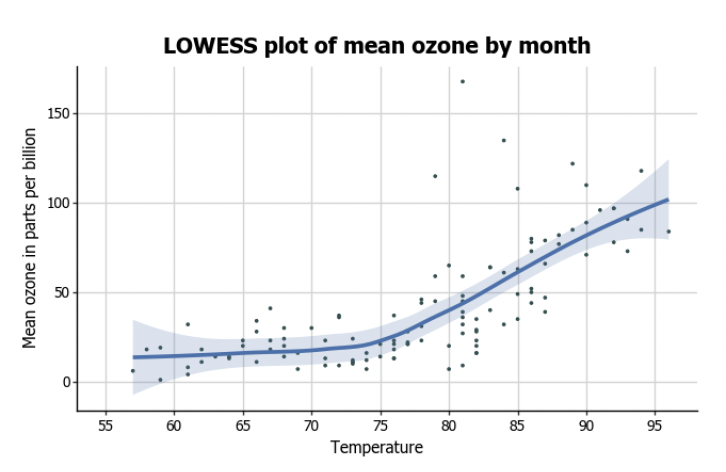

第一步是导入所有需要的包。为此，需要：
- pandas和它的DataFrame类来读入和处理数据
- plotnine来获取数据并创建图表
-numpy，以便在图表中进行一些基本的数学运算。 还可以使用 plotnine 的 figure_size 函数来改变图形的大小，使图表显示得更 整洁。

In [1]:
import numpy as np
import pandas as pd
import plotnine
plotnine.options.figure_size=(7.5, 4.2)
from plotnine import *
from pandas import DataFrame

C:\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1


在本章中，将使用空气质量数据集。

In [1]:
airquality = pd.read_csv(
"we.csv", header=0,
usecols=np.arange(1, 7, 1),
)

NameError: name 'pd' is not defined

## 12.2 ggplot的基本结构
为了初始化一个LOWESS图，需要告诉ggplot，空气质量是数据。 并指定X轴绘制温度变量，Y轴绘制臭氧变量。把x轴和y轴变量放在了 aes方法中。aes是美学映射的简称，aes决定了不同变量如何到图形的哪个部分。 ggplot将Temp变量映射到X轴上，将Ozone变量映射到 y轴。 图中没有任何结果，如图 12-2。为了渲染数据，需要告诉ggplot该如何直观地表现它。

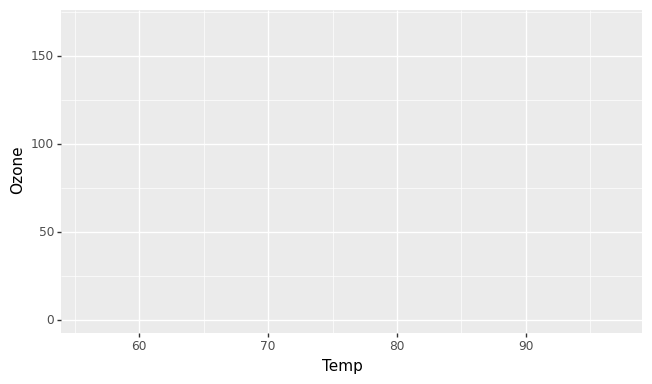

<ggplot: (172672314643)>

In [3]:
p12 = ggplot(airquality, aes("Temp", "Ozone"))
p12

## 12.3 创建一个基本的LOWESS图
可以通过添加geom_smooth(method="loess")选项在图表中添加一个LOWESS曲线。 stat_smooth的默认值是包括置信区间的。 也可以通过使用 method="loess "来创建一个简单的 LOWESS 图表（没有置信区间）。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 37 rows containing missing values.


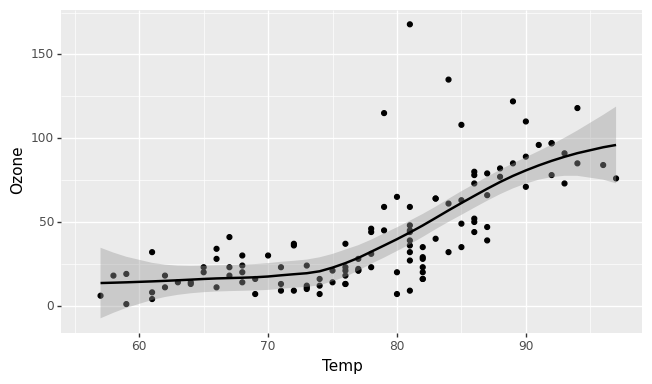

<ggplot: (172705973764)>

In [4]:
p12 = (ggplot(airquality, aes("Temp", "Ozone")) + geom_point()
+ geom_smooth(method="loess"))
p12

可以看到，虽然温度和臭氧之间的关系是相当线性的。 LOWESS图显示，可能存在一个阈值效应，即当温度超过华氏75度时，臭氧才开始增加。为了 为了评估是否存在这种情况，注意观察这些变量之间的线性拟合情况，如图 12-3所示。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 37 rows containing missing values.


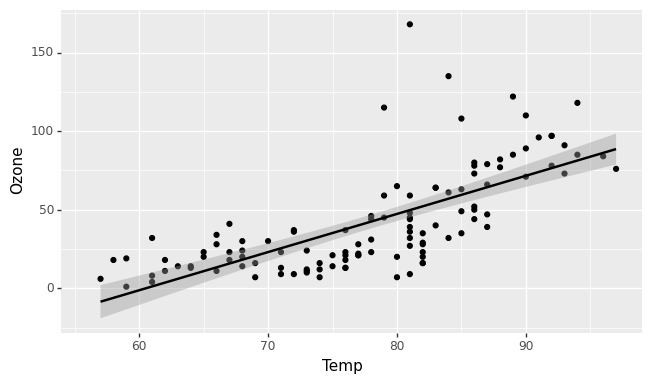

<ggplot: (172703703465)>

In [5]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point()
+ geom_smooth(method="lm")
)
p12

现在让来看看它对臭氧水平的变量的解释。 从这两个变量之间的线性回归模型中提取调整后的R2 变量

In [6]:
import statsmodels.formula.api as smf
model = smf.ols(formula="Ozone ~ Temp", data=airquality).fit()
model.rsquared_adj

0.48321337071275583

可以看到，该线在几个点上偏离了数据，这将增加回归模型的误差，并降低整体的 R2. 现在看看是否可以通过拟合二次模型得到更好的结果。 这能更好地反映出LOWESS图中的曲线。

In [7]:
model = smf.ols(formula="Ozone ~ I(Temp**2) + Temp", data=airquality).fit()
model.rsquared_adj

0.5361500925810914

可以看到这里已经成功地解释了额外的臭氧水平5％的变异。使用 LOWESS 图来探索变量之间的关系可以，在选择正确的回归模型时，它可以用一种相当轻松的方式指导你.

## 12.4 改变分层的宽度
拟合 LOWESS 曲线的一个重要部分是，可以通过参数 n 来改变 X 轴上的分选区数量。 这会使曲线更加平滑，而较小的n则会使曲线更加接近线性。n的默认数字 是80，这里把它改成5，这样就可以看到区别了，如图 12-4所示。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 37 rows containing missing values.


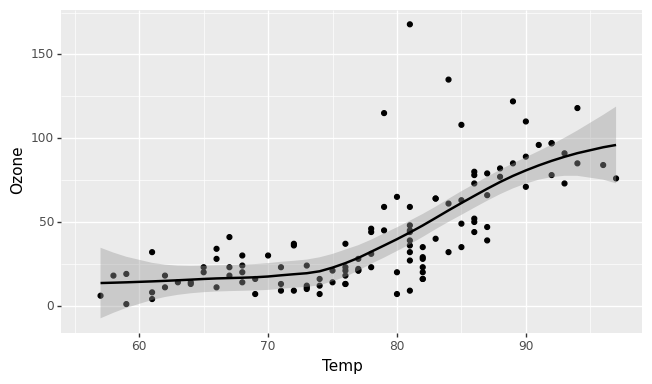

<ggplot: (172705967544)>

In [8]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point()
+ geom_smooth(method="loess", n=5)
)
p12

## 12.5 调整轴的刻度
使用scale_x_continuous方法改变X轴的刻度线。同理。 可以使用scale_y_continuous方法改变Y轴，将X轴改为每5度并将范围设为从55到95，可以使用break选项来改变断点，该选项需要一个 列表作为参数。可以用numpy的的range函数来缩短手动输入整个列表的时间，该函数从选择的初始值、停止和步长值中生成一个序列。 同样地，可以使用 limits参数来定义你的轴的最小和最大值。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


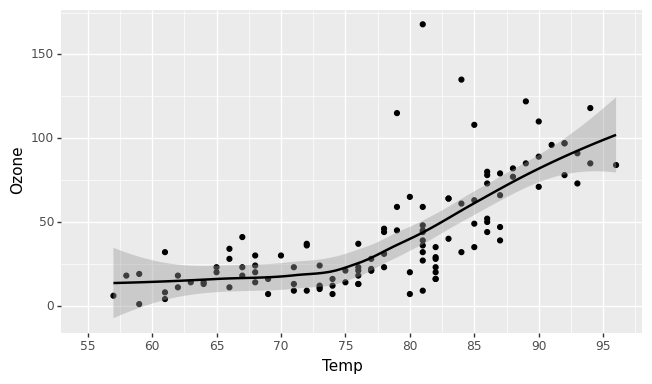

<ggplot: (172706054840)>

In [9]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point()
+ geom_smooth(method="loess")
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
)
p12

## 12.6 调整轴标签和添加标题
为了添加标题，在ggtitle中加入了图形的名称参数。要改变轴的名称同样要使用xlab和 ylab方法，如图 12-5所示。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


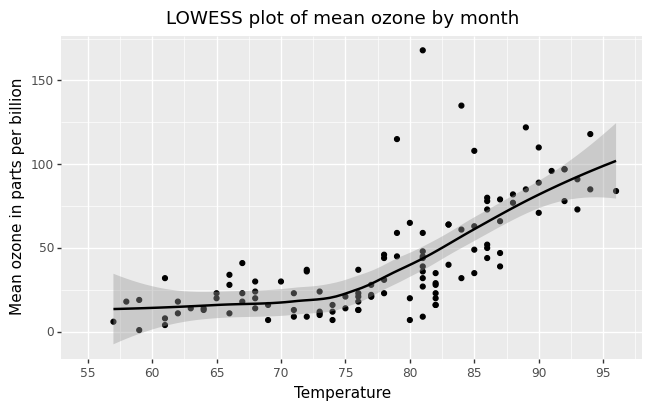

<ggplot: (172706198866)>

In [10]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point()
+ geom_smooth(method="loess")
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
)
p12

## 12.7 改变 LOWESS 曲线的颜色
要改变 LOWESS 曲线的颜色，需要在 geom_smooth() 的颜色参数中添加一个有效的颜色。  plotnine 使用 调色板， ggplot所能识别matplotlib 的所有颜色，试着把颜色改为 rebecca紫色，如图 12-6所示。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


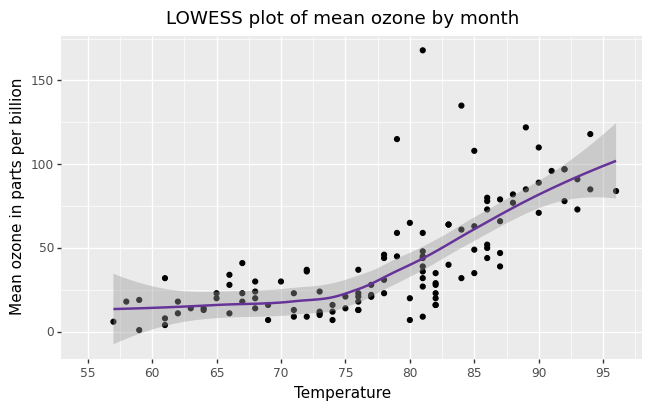

<ggplot: (172706196682)>

In [11]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point()
+ geom_smooth(method="loess", colour="rebeccapurple")
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
)
p12

可以使用特定的HEX代码来改变颜色。在这里，把颜色定义为 "#4271AE"（钢蓝色），如图 12-7所示。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


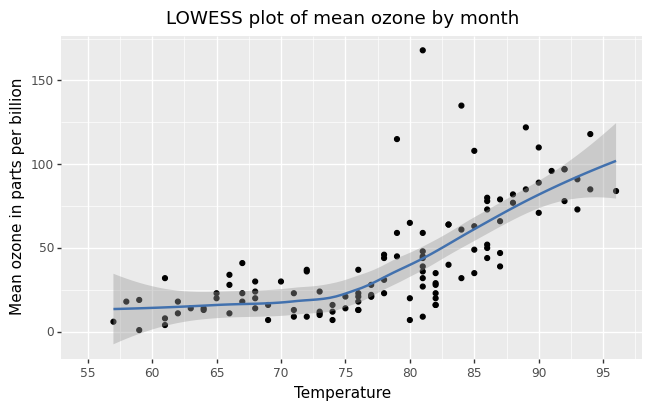

<ggplot: (172703708109)>

In [12]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point()
+ geom_smooth(method="loess", colour="#4271AE")
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
)
p12

还可以使用geom_-中的size方法来增加线条的厚度，如图 12-8所示。 

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


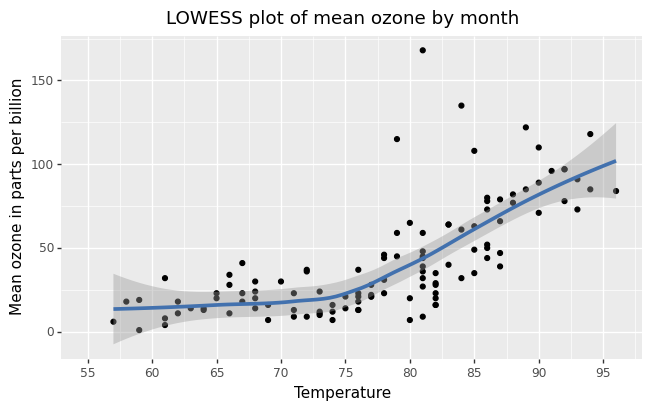

<ggplot: (172706232528)>

In [13]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point()
+ geom_smooth(method="loess", colour="#4271AE", size=1.5)
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
)
p12

## 12.8 改变置信区间的外观
此外，还可以改变 LOWESS 曲线周围的置信区间的外观，如图 12-9所示。可以使用 geom_-中的参数 alpha 来改变透明度。 这个参数的范围是从0到1。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


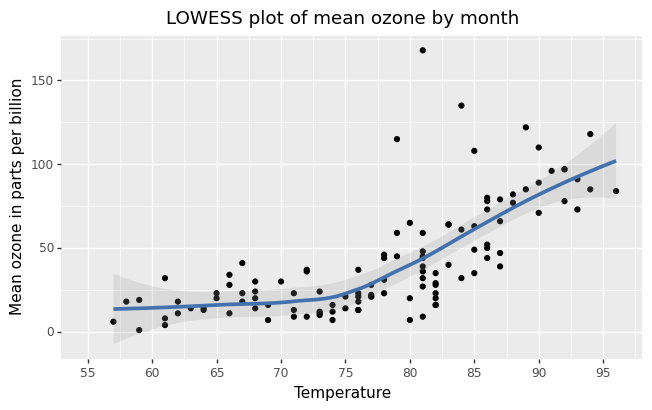

<ggplot: (172706110992)>

In [14]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point()
+ geom_smooth(method="loess", colour="#4271AE", size=1.5,
alpha=0.2)
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
)
p12

还可以使用参数fill来改变置信区间的颜色， 把它改成与LOWESS 曲线一样的蓝色。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


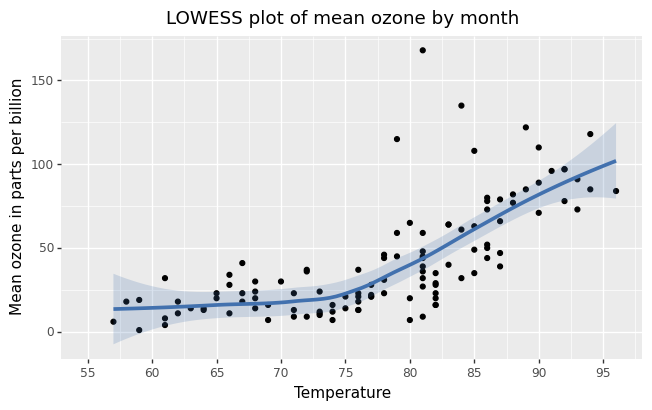

<ggplot: (172706463892)>

In [15]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point()
+ geom_smooth(method="loess", colour="#4271AE",
size=1.5, alpha=0.2, fill="#4271AE")
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
)
p12

最后，也可以通过在geom_smooth()函数中添加参数 se=False来关闭置信区间的显示，如图 12-11所示。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


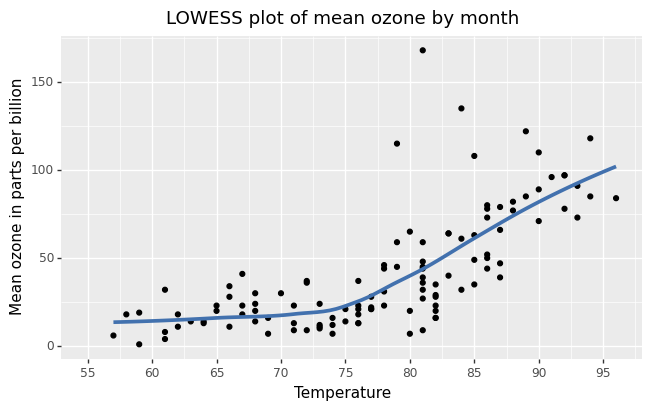

<ggplot: (172703710919)>

In [16]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point()
+ geom_smooth(
method="loess", colour="#4271AE", size=1.5,
alpha=0.2, fill="#4271AE", se=False
)+
scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
)
p12

## 12.9 改变散点图的外观
还可以自定义曲线下的散点图的外观。如希望数据点的形状与实心圆不同，可以 可以通过在geom_point中添加形状参数来达到目的。plotnine 的形状参数与 与 matplotlib 中的参数相同，使用参数". "将所有的标记改为小圆点。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


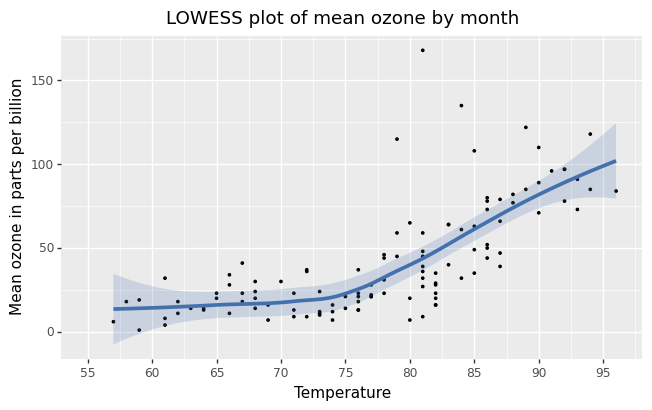

<ggplot: (172706827189)>

In [17]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point(shape=".")
+ geom_smooth(method="loess", colour="#4271AE", size=1.5, alpha=0.2,
fill="#4271AE")
+ scale_x_continuous(breaks=np.arange(55, 96, 5), limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature") + ylab("Mean ozone in parts per billion")
)
p12

同样也可以通过在geom_point()中添加一个颜色参数来改变点的颜色，如图 12-13所示。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


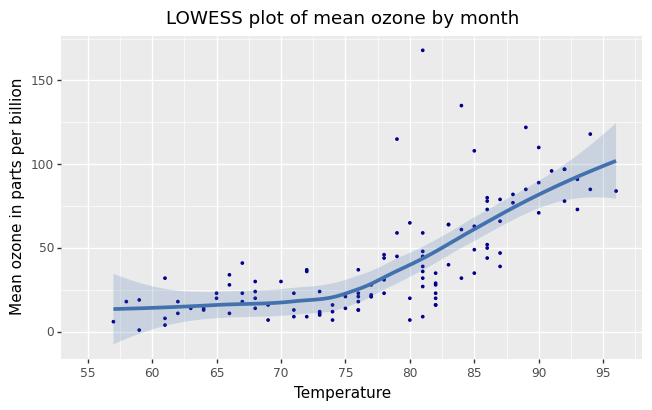

<ggplot: (172706874615)>

In [18]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point(shape=".", colour="darkblue")
+ geom_smooth(method="loess", colour="#4271AE",
size=1.5, alpha=0.2, fill="#4271AE")
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
)
p12

也可以通过删除geom_point()方法来完全去除点，如图 12-14所示。

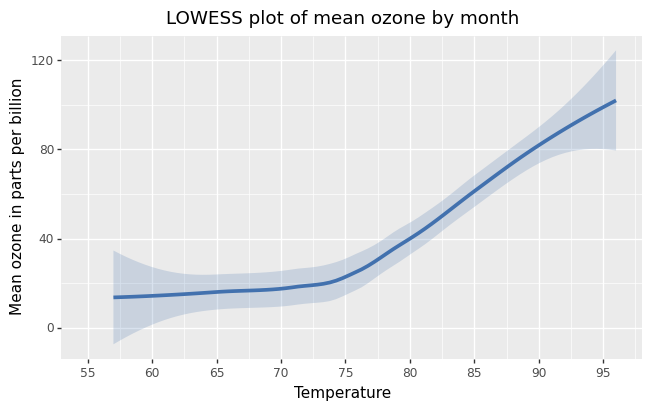

<ggplot: (172706887455)>

In [19]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_smooth(method="loess", colour="#4271AE",
size=1.5, alpha=0.2, fill="#4271AE")
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
)
p12

## 12.10 使用白色主题
也可以通过主题来改变图表的整体外观可以在ggplot()后面添加 theme_bw()之后开始使用一个简单的主题定制，如图 12-15所示。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


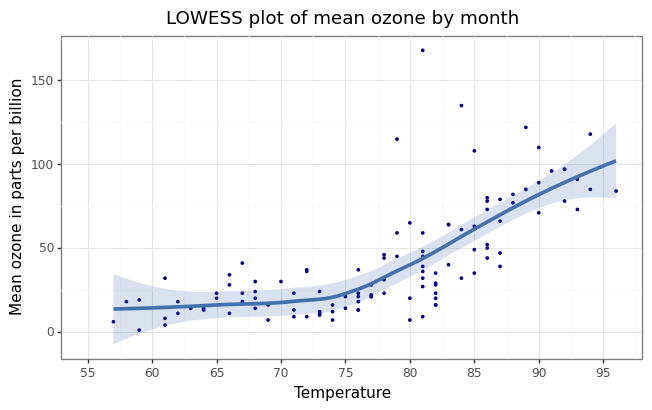

<ggplot: (172707283725)>

In [20]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point(shape=".", colour="darkblue")
+ geom_smooth(method="loess", colour="#4271AE",
size=1.5, alpha=0.2, fill="#4271AE")
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
+ theme_bw()
)
p12

## 12.11 创建一个XKCD风格的图表
当然自己的主题具有非常高的定制化程度，包括允许使用导入字体。 plotnine 已经有一个 theme_xkcd() 实现，但这里还是从头开始创建了一个，为了创建这个图表，首先需要下载XKCD字体。 一旦有了字体，就可以使用使用matplotlib.font_manager类把它加载到 到Python中。

In [21]:
import matplotlib.font_manager as fm
fpath = "xkcd-Regular.otf"

由于这是一种导入的字体，不能在图形中直接改变其大小。 相反，需要改变我们导入的字体对象来改变其大小。由于希望标题和正文有不同的字体大小，将创建两个不同的 字体对象，title_text和body_set。
然后可以在这些对象上调用方法。对于标题，把字体改为18号，并使用 set_size()和set_weight方法将其改为粗体。同样地，把正文的字号改为 改为12号。

In [22]:
# Create font objects
title_text = fm.FontProperties(fname=fpath)
body_text = fm.FontProperties(fname=fpath)
# Alter size and weight of font objects
title_text.set_size(18)
title_text.set_weight("bold")
body_text.set_size(12)

为了使情节看起来更像XKCD的艺术风格，将做一些更多的变化，如图 12-16所示。
- 改变 axis_line_x 和 axis_line_y 的值可以改变轴线的粗细
- 将 legend_key 的参数设置为 element_blank()，可以去除图例周围的方框
- 为了去掉网格线，需要改变四个参数的值。 panel_grid_major, panel_grid_minor, panel_border 和 panel_background。
- 为了使用刚刚导入的XKCD字体，需要改变plot_title和text的值。
- 最后，为了将文本的颜色改为黑色（从其默认的灰色）要改变 axis_text_x 和 axis_text_y 的值。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


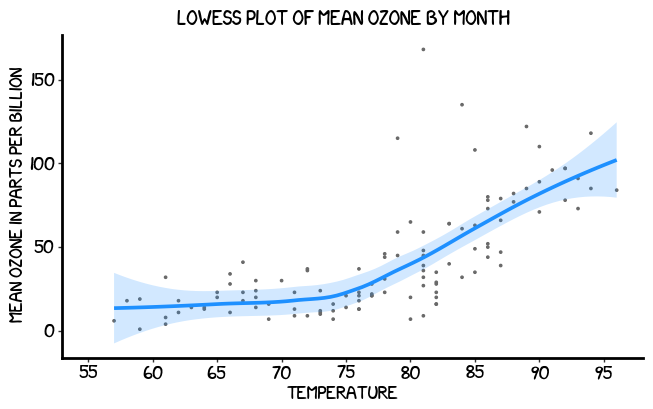

<ggplot: (172707330467)>

In [23]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point(shape=".", colour="dimgrey")
+ geom_smooth(
method="loess", colour="dodgerblue",
size=1.5, alpha=0.2, fill="dodgerblue"
)+
scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
+ theme(
axis_line_x=element_line(size=2, colour="black"),
    axis_line_y=element_line(size=2, colour="black"),
legend_key=element_blank(),
panel_grid_major=element_blank(),
panel_grid_minor=element_blank(),
panel_border=element_blank(),
panel_background=element_blank(),
plot_title=element_text(fontproperties=title_text),
text=element_text(fontproperties=body_text),
axis_text_x=element_text(colour="black"),
axis_text_y=element_text(colour="black"),
)
)
p12

## 12.12 使用 "538 "主题
ggplot软件包有更多的预建主题可供选择，下面应用了theme_538()，如图 12-17所示。 它接近于FiveThirtyEight网站上的图形。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


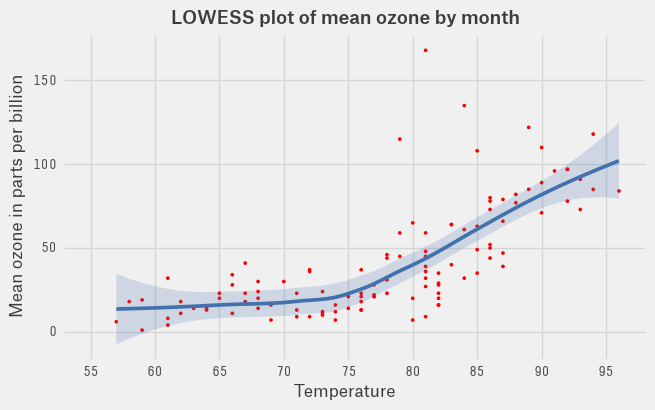

<ggplot: (172707376354)>

In [24]:
agm = "AtlasGrotesk-Medium.otf"
agr = "AtlasGrotesk-Regular.otf"
dp = "DecimaMonoPro.otf"
# Create font objects
title_text = fm.FontProperties(fname=agm)
axis_text = fm.FontProperties(fname=agr)
body_text = fm.FontProperties(fname=dp)
# Alter size and weight of font objects
title_text.set_size(16)
axis_text.set_size(12)
body_text.set_size(10)
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point(shape=".", colour="red")
+ geom_smooth(method="loess", colour="#4271AE",
size=1.5, alpha=0.2, fill="#4271AE")
+ scale_x_continuous(breaks=np.arange(55, 96, 5),
limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
+ theme_538()
+ theme(
axis_title=element_text(fontproperties=axis_text),
plot_title=element_text(fontproperties=title_text),
text=element_text(fontproperties=body_text),
)
)
p12

## 12.13 创建自己的主题
现在已经探索了图表定制中的一些可用选项。现在可以建立自己的完全定制的图表。

- 改变 axis_line 的大小和颜色参数，可以加粗线条，并将其颜色改为黑色
- 改变传递给panel_grid_major的颜色参数意味着所有的主要网格线现在是浅灰色的
- 通过改变 panel_grid_major 的参数来去除次要网格线和背景。 同样，我们通过改变 panel_grid_minor、panel_border 和 panel_background 的参数来去除次要网格线和背景。

使用字体Tahoma字体。 通过所有这些定制，现在终于有了我们在本章开始时提出的图形，如图 12-18所示。

C:\Users\xu\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 38 rows containing missing values.


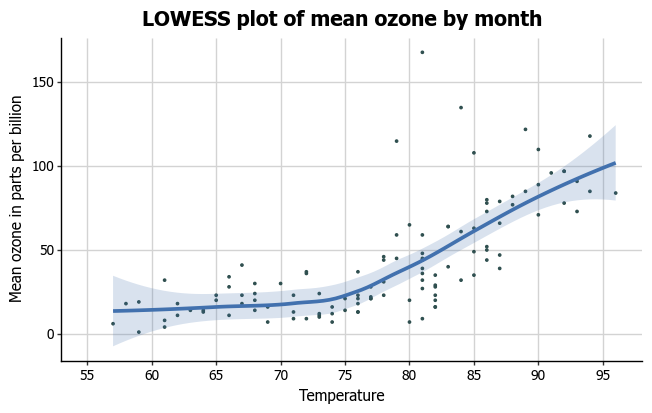

<ggplot: (172706938884)>

In [25]:
p12 = (
ggplot(airquality, aes("Temp", "Ozone"))
+ geom_point(shape=".", colour="darkslategrey")
+ geom_smooth(method="loess", colour="#4271AE",
size=1.5, alpha=0.2, fill="#4271AE")
+ scale_x_continuous(breaks=np.arange(55, 96, 5),limits=[55, 96])
+ ggtitle("LOWESS plot of mean ozone by month")
+ xlab("Temperature")
+ ylab("Mean ozone in parts per billion")
+ theme(
axis_line=element_line(size=1, colour="black"),
panel_grid_major=element_line(colour="#d3d3d3"),
panel_grid_minor=element_blank(),
panel_border=element_blank(),
panel_background=element_blank(),
plot_title=element_text(size=15, family="Tahoma",
face="bold"),
text=element_text(family="Tahoma", size=11),
axis_text_x=element_text(colour="black", size=10),
axis_text_y=element_text(colour="black", size=10),
)
)
p12
                     